## 1. Import dataset and libraries

In [ ]:
import pandas as pd
heart_df = pd.read_csv("heart_disease_uci.csv")
heart_df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

## 2. Data Overview

In [ ]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [ ]:
# Type of variables column

categorical_cols = heart_df.select_dtypes(include=['object']).columns.tolist()  # Define categorical column
numerical_cols = heart_df.select_dtypes(include=['number']).columns.tolist()  # Define numeric (int, float) column

# Print result
print('Categorical variables are:', categorical_cols)
print('Numerical variables are:', numerical_cols)


Categorical variables are: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Numerical variables are: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']


### 2.1. Checking duplicate values

In [ ]:
# Check the number of duplicate rows before dropping them
print("Number of duplicate rows :", heart_df.duplicated().sum())
print() # Result = 0 so there is no duplicate rows to deal

Number of duplicate rows : 0



### 2.2. Checking missing values (null values)

In [ ]:
missing_count = heart_df.isnull().sum()
missing_percentage = (heart_df.isnull().mean() * 100).round(2)

missing_data = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage (%)': missing_percentage
})

print("Check null values in each column:")
print(missing_data.sort_values(by='Missing Percentage (%)', ascending=False))


Check null values in each column:
          Missing Count  Missing Percentage (%)
ca                  611                   66.41
thal                486                   52.83
slope               309                   33.59
fbs                  90                    9.78
oldpeak              62                    6.74
trestbps             59                    6.41
thalch               55                    5.98
exang                55                    5.98
chol                 30                    3.26
restecg               2                    0.22
id                    0                    0.00
age                   0                    0.00
sex                   0                    0.00
dataset               0                    0.00
cp                    0                    0.00
num                   0                    0.00


## 3. Data Preprocessing

### 3.1. Drop columns:

In [ ]:
#Drop ID column
heart_df.drop(['id'], axis=1, inplace=True)

In [ ]:
heart_df = heart_df.dropna(subset=['restecg']) # With less than 5% of missing values ratio, we drop it

### 3.2. Checking categorical variables

In [ ]:
for column in categorical_cols:
    print(f"Unique values in '{column}' is:")
    unique_values = heart_df[column].unique()
    for value in unique_values:
        print(f"- {value}")
    print()


Unique values in 'sex' is:
- Male
- Female

Unique values in 'dataset' is:
- Cleveland
- Hungary
- Switzerland
- VA Long Beach

Unique values in 'cp' is:
- typical angina
- asymptomatic
- non-anginal
- atypical angina

Unique values in 'fbs' is:
- True
- False
- nan

Unique values in 'restecg' is:
- lv hypertrophy
- normal
- st-t abnormality

Unique values in 'exang' is:
- False
- True
- nan

Unique values in 'slope' is:
- downsloping
- flat
- upsloping
- nan

Unique values in 'thal' is:
- fixed defect
- normal
- reversable defect
- nan



There is no typo values so we do not need to form it

In [ ]:
# i.e. 'typical angina' to 'typical-angina', 'atypical angina' to 'atypical-angina'.
heart_df['cp'] = heart_df['cp'].map({'typical angina': 'typical_angina', 'asymptomatic': 'asymptomatic', 'non-anginal': 'non_anginal', 'atypical angina': 'atypical_angina'})

heart_df['restecg'] = heart_df['restecg'].map({'lv hypertrophy': 'lv_hypertrophy', 'normal': 'normal', 'st-t abnormality': 'st_t_abnormality'})

heart_df['thal'] = heart_df['thal'].map({'normal': 'normal', 'fixed defect': 'fixed_defect', 'reversable defect': 'reversable_defect'})

heart_df['dataset'] = heart_df['dataset'].map({'Cleveland': 'Cleveland', 'Hungary': 'Hungary', 'Switzerland': 'Switzerland', 'VA Long Beach': 'VA-Long-Beach'})

In [ ]:
# Check zero value in numerical columns
numeric_cols_need_to_clean = ['trestbps', 'chol']

for col in numeric_cols_need_to_clean:
    print("Zero values in '"+ col + "'=", heart_df[col][heart_df[col]==0].count())

Zero values in 'trestbps'= 1
Zero values in 'chol'= 171


In [ ]:
# Replace the zero values in 'trestbps' and 'chol' with NaN.
for col in numeric_cols_need_to_clean:
    heart_df[col][heart_df[col] == 0] = np.nan

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8056\3046021867.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  heart_df[col][heart_df[col] == 0] = np.nan
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8056\3046021867.py:3: SettingWithCopyWarning

In [ ]:
# Verify the 'Zero' values in 'trestbps' and 'chol' replaced with NaN.
for col in numeric_cols_need_to_clean:
    print("Zero values in '"+ col + "'=", heart_df[col][heart_df[col]==0].count())

Zero values in 'trestbps'= 0
Zero values in 'chol'= 0


In [ ]:
# Check null values after define zelo values as NAN:
missing_count = heart_df.isnull().sum()
missing_percentage = (heart_df.isnull().mean() * 100).round(2)

missing_data = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage (%)': missing_percentage
})

print("Check null values in each column:")
print(missing_data.sort_values(by='Missing Percentage (%)', ascending=False))

Check null values in each column:
          Missing Count  Missing Percentage (%)
ca                  609                   66.34
thal                484                   52.72
slope               308                   33.55
chol                201                   21.90
fbs                  89                    9.69
oldpeak              62                    6.75
trestbps             60                    6.54
thalch               55                    5.99
exang                55                    5.99
age                   0                    0.00
sex                   0                    0.00
dataset               0                    0.00
cp                    0                    0.00
restecg               0                    0.00
num                   0                    0.00


In [ ]:
# create an object of iterative imputer
imputer1 = IterativeImputer(max_iter=10, random_state = 42)

# fit transform on ca,oldpeak, thal,chol and thalch columns
heart_df['oldpeak']= imputer1.fit_transform(heart_df[['oldpeak']])
heart_df['chol'] = imputer1.fit_transform(heart_df[['chol']])
heart_df['thalch'] = imputer1.fit_transform(heart_df[['thalch']])
heart_df['trestbps'] = imputer1.fit_transform(heart_df[['trestbps']])

In [ ]:
# Check null values after define zelo values as NAN:
missing_count = heart_df.isnull().sum()
missing_percentage = (heart_df.isnull().mean() * 100).round(2)

missing_data = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage (%)': missing_percentage
})

print("Check null values in each column:")
print(missing_data.sort_values(by='Missing Percentage (%)', ascending=False))

Check null values in each column:
          Missing Count  Missing Percentage (%)
ca                  609                   66.34
thal                484                   52.72
slope               308                   33.55
fbs                  89                    9.69
exang                55                    5.99
age                   0                    0.00
sex                   0                    0.00
dataset               0                    0.00
cp                    0                    0.00
trestbps              0                    0.00
chol                  0                    0.00
restecg               0                    0.00
thalch                0                    0.00
oldpeak               0                    0.00
num                   0                    0.00


In [ ]:
missing_data_cols = heart_df.isnull().sum()[heart_df.isnull().sum()>0].index.tolist()


In [ ]:
categorical_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
numerical_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

In [ ]:
# This function imputes missing values in categorical columns
def impute_categorical_missing_data(passed_col):
    df_null = heart_df[heart_df[passed_col].isnull()]
    df_not_null = heart_df[heart_df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [col for col in missing_data_cols if col != passed_col]

    label_encoder = LabelEncoder()
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)

    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):

    df_null = heart_df[heart_df[passed_col].isnull()]
    df_not_null = heart_df[heart_df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [col for col in missing_data_cols if col != passed_col]

    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]

In [ ]:
# remove warning
import warnings
warnings.filterwarnings('ignore')

# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((heart_df[col].isnull().sum() / len(heart_df)) * 100, 2))+"%")
    if col in categorical_cols:
        heart_df[col] = impute_categorical_missing_data(col)
    elif col in numerical_cols:
        heart_df[col] = impute_continuous_missing_data(col)
    else:
        pass

Missing Values fbs : 9.69%
The feature 'fbs' has been imputed with 81.33 accuracy

Missing Values exang : 5.99%
The feature 'exang' has been imputed with 77.46 accuracy

Missing Values slope : 33.55%
The feature 'slope' has been imputed with 68.85 accuracy

Missing Values ca : 66.34%
The feature 'ca' has been imputed with 67.74 accuracy

Missing Values thal : 52.72%
The feature 'thal' has been imputed with 72.41 accuracy



In [ ]:
print("Finally check null values in each column: ")
heart_df.isnull().sum().sort_values(ascending=False)

Finally check null values in each column: 


age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [ ]:
# Summary
# Step 1: If missing ratio < 5% => drop
# Step 2: Dealing with missing value in numerical columns (Check zero values and change it into NAN before imputation)
# Step 3: Dealing with missing value in categorical columns

In [ ]:
heart_df.to_excel('prepocessed_heart_data.xlsx', index=False)

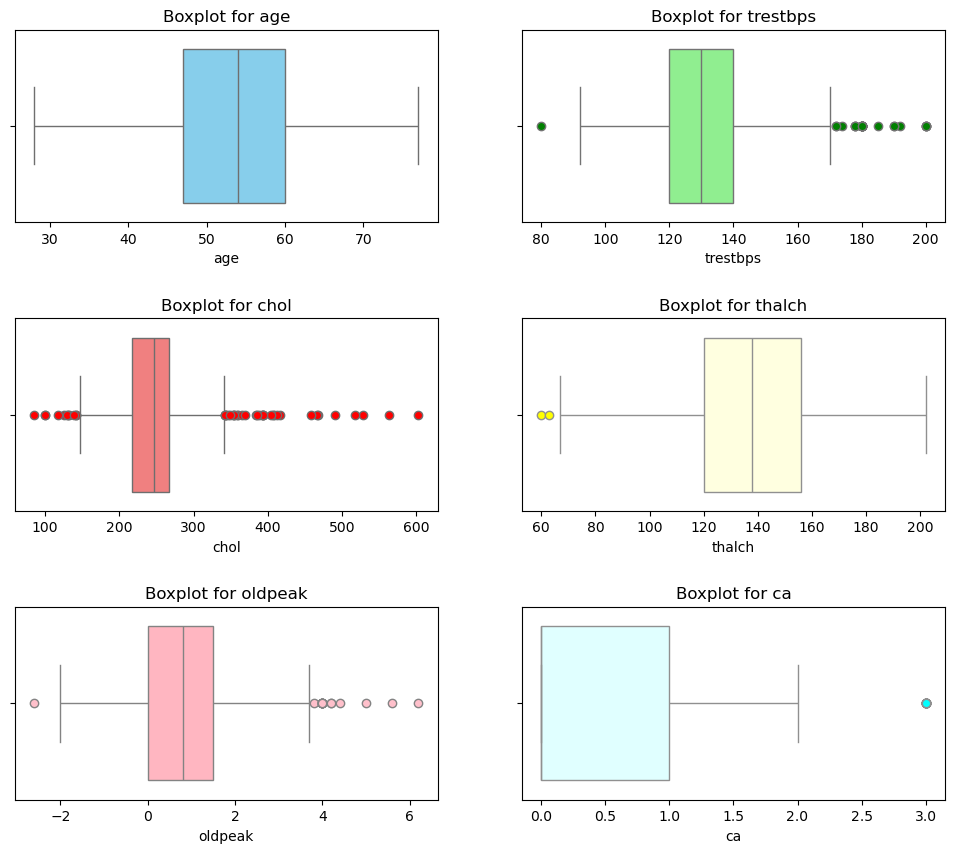

In [ ]:
# Assuming you have a DataFrame named 'df' containing the data

boxplot_columns = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.5)

# Define custom colors for boxes and outliers
box_colors = ["skyblue", "lightgreen", "lightcoral", "lightyellow", "lightpink", "lightcyan"]
outlier_colors = ["blue", "green", "red", "yellow", "pink", "cyan"]

# Plot boxplots for each numeric column with custom colors
for i, column in enumerate(boxplot_columns):
    row = i // 2
    col = i % 2
    sns.boxplot(x=heart_df[column], ax=axes[row, col], color=box_colors[i], boxprops=dict(facecolor=box_colors[i]),
                flierprops=dict(markerfacecolor=outlier_colors[i], marker="o")).set(title=f'Boxplot for {column}')

# Show the plots
plt.show()